# RIM Data Analysis Notebook

This notebook provides tools for analyzing processed RIM experiment data. It loads DataFrames from pickle files created by the bag data processing script and provides visualization and comparison capabilities for multiple experiments.

## Features
- Load and compare multiple experiments
- Time-series plotting with overlay capabilities  
- Statistical analysis of position tracking performance
- Haptic pose vs current pose tracking analysis

In [45]:
# Install missing packages if needed
# %pip install seaborn scipy

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional
import yaml
from scipy import stats
from scipy.spatial.transform import Rotation
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

# Configuration
DATA_DIR = Path("../data")  # Relative to scripts directory
PROCESSED_DATA_FILENAME = "int_force_free_space.pkl"

print("Libraries imported successfully!")
print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Available experiments will be searched for files named: {PROCESSED_DATA_FILENAME}")

Libraries imported successfully!
Data directory: /home/ros/ros2_ws/src/adg-ros2/scripts/../data
Available experiments will be searched for files named: int_force_free_space.pkl


## Data Loading Functions

Functions to discover and load processed experiment data from pickle files.

In [46]:
def normalize_timestamps(df, reference_timestamp=None):
    """
    Convert timestamps to seconds relative to a reference timestamp.
    If no reference is provided, uses the first timestamp of the dataframe.
    """
    df_copy = df.copy()

    # Determine reference timestamp
    if reference_timestamp is None:
        reference_timestamp = df_copy["timestamp"].min()

    # Convert timestamp from nanoseconds to seconds if it's a large number
    if df_copy["timestamp"].min() > 1e15:  # Likely nanoseconds
        df_copy["timestamp_seconds"] = (df_copy["timestamp"] - reference_timestamp) / 1e9
    else:  # Already in seconds
        df_copy["timestamp_seconds"] = df_copy["timestamp"] - reference_timestamp

    return df_copy

def discover_processed_experiments(data_dir: Path) -> List[str]:
    """Discover all experiments with processed data files."""
    experiments = []
    for experiment_dir in data_dir.iterdir():
        if experiment_dir.is_dir() and experiment_dir.name.startswith("franka_rim_data_"):
            processed_file = experiment_dir / PROCESSED_DATA_FILENAME
            if processed_file.exists():
                experiments.append(experiment_dir.name)

    return sorted(experiments)


def load_experiment_data(experiment_name: str, data_dir: Path = DATA_DIR) -> Dict:
    """Load processed data for a specific experiment."""
    experiment_path = data_dir / experiment_name / PROCESSED_DATA_FILENAME

    if not experiment_path.exists():
        raise FileNotFoundError(f"Processed data not found: {experiment_path}")

    data = pd.read_pickle(experiment_path)

    # Get reference timestamp from fr3_pose for proper alignment
    dataframes = data["dataframes"]
    fr3_pose_df = dataframes.get("fr3_pose")

    if fr3_pose_df is not None and len(fr3_pose_df) > 0:
        reference_timestamp = fr3_pose_df["timestamp"].min()
        print(f"Using fr3_pose start time as reference: {reference_timestamp}")

        # Normalize all dataframes with the same reference timestamp
        for df_name, df in dataframes.items():
            if "timestamp" in df.columns:
                dataframes[df_name] = normalize_timestamps(df, reference_timestamp)
                print(f"  Normalized {df_name}: {len(df)} rows")
    else:
        print(f"Warning: No fr3_pose data found for {experiment_name}, timestamps not normalized")

    print(f"Loaded experiment: {experiment_name}")
    print(f"  Available DataFrames: {list(data['dataframes'].keys())}")
    print(f"  Processing timestamp: {data['metadata']['processing_timestamp']}")

    return data


def load_multiple_experiments(experiment_names: List[str], data_dir: Path = DATA_DIR) -> Dict[str, Dict]:
    """Load data for multiple experiments."""
    all_data = {}

    for exp_name in experiment_names:
        try:
            all_data[exp_name] = load_experiment_data(exp_name, data_dir)
        except FileNotFoundError as e:
            print(f"Warning: {e}")
            continue

    return all_data


# Discover available experiments
available_experiments = discover_processed_experiments(DATA_DIR)
print(f"\nAvailable processed experiments ({len(available_experiments)}):")
for exp in available_experiments:
    print(f"  - {exp}")


Available processed experiments (4):
  - franka_rim_data_20250911_145004
  - franka_rim_data_20250911_185005
  - franka_rim_data_20250911_202012
  - franka_rim_data_20250911_202557


## Experiment Selection and Loading

Specify which experiments you want to analyze and load their data.

In [47]:
# Specify experiments to analyze
# Modify this list with the experiments you want to compare
EXPERIMENTS_TO_ANALYZE = [
    "franka_rim_data_20250911_145004",
    # "franka_rim_data_20250911_185005",
    "franka_rim_data_20250911_202012",
    "franka_rim_data_20250911_202557",

]

# If no experiments specified, use the most recent ones
if not EXPERIMENTS_TO_ANALYZE:
    EXPERIMENTS_TO_ANALYZE = available_experiments[-2:] if len(available_experiments) >= 2 else available_experiments
    print(f"Auto-selected experiments: {EXPERIMENTS_TO_ANALYZE}")

# Load the selected experiments
experiments_data = load_multiple_experiments(EXPERIMENTS_TO_ANALYZE)

# Display summary of loaded data
print(f"\nLoaded {len(experiments_data)} experiments:")
for exp_name, exp_data in experiments_data.items():
    print(f"\n{exp_name}:")
    dataframes = exp_data["dataframes"]
    for df_name, df in dataframes.items():
        print(f"  {df_name}: {len(df)} rows, {len(df.columns)} columns")
        if "timestamp" in df.columns:
            duration = df["timestamp"].max() - df["timestamp"].min()
            print(f"    Duration: {duration:.2f} seconds")

Using fr3_pose start time as reference: 1757602205.9263124
  Normalized fr3_interface_force: 20861 rows
  Normalized rim_force: 10626 rows
  Normalized rendered_force: 10626 rows
  Normalized fr3_joint_states: 655 rows
  Normalized fr3_pose: 20856 rows
  Normalized haptic_pose: 10618 rows
  Normalized rim_pose: 10255 rows
Loaded experiment: franka_rim_data_20250911_145004
  Available DataFrames: ['fr3_interface_force', 'rim_force', 'rendered_force', 'fr3_joint_states', 'fr3_pose', 'haptic_pose', 'rim_pose']
  Processing timestamp: 2025-09-15T16:16:27.573176
Using fr3_pose start time as reference: 1757622013.70002
  Normalized fr3_interface_force: 19736 rows
  Normalized rendered_force: 1963 rows
  Normalized fr3_joint_states: 592 rows
  Normalized fr3_pose: 19732 rows
  Normalized haptic_pose: 1963 rows
Loaded experiment: franka_rim_data_20250911_202012
  Available DataFrames: ['fr3_interface_force', 'rendered_force', 'fr3_joint_states', 'fr3_pose', 'haptic_pose']
  Processing timestam

## Time-Series Plotting Functions

Functions for plotting and comparing time-series data across multiple experiments.

In [48]:
def plot_force_comparison(experiments_data, save_path=None):
    """
    Plot force and torque comparison between experiments.
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    # Colors for different experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(experiments_data)))

    for i, (exp_name, exp_data) in enumerate(experiments_data.items()):
        dataframes = exp_data["dataframes"]
        fr3_force_df = dataframes.get("fr3_interface_force")
        rim_force_df = dataframes.get("rim_force")
        rendered_force_df = dataframes.get("rendered_force")

        color = colors[i]
        label = exp_name.replace("franka_rim_data_", "")

        #! Plots
        # Control force
        if fr3_force_df is not None:
            axes[0].plot(
                fr3_force_df["timestamp_seconds"],
                fr3_force_df["force_x"],
                label=f"{label} - Control",
                color=color,
                alpha=0.8,
                linestyle="-",
            )

            # axes[0].plot(
            #     force_df["timestamp_seconds"],
            #     force_df["force_y"],
            #     label=f"{label} - Fy",
            #     color=color,
            #     alpha=0.8,
            #     linestyle="--",
            # )

        # RIM force
        if rim_force_df is not None:
            axes[1].plot(
                rim_force_df["timestamp_seconds"],
                rim_force_df["force_x"],
                label=f"{label} - RIM",
                color=color,
                alpha=0.8,
                linestyle="-",
            )

        if rendered_force_df is not None:
            axes[2].plot(
                rendered_force_df["timestamp_seconds"],
                rendered_force_df["force_y"],
                label=f"{label} - Rendered",
                color=color,
                alpha=0.8,
                linestyle="-",
            )

    # Configure controller interface force plot
    axes[0].set_title("Interface Forces - Controller")
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Force [N]")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Configure rim interface force plot
    axes[1].set_title("Interface Forces - RIM")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Force [N]")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Configure rendered force plot
    axes[2].set_title("Rendered Forces - I3")
    axes[2].set_xlabel("Time [s]")
    axes[2].set_ylabel("Force [N]")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Force comparison plot saved to: {save_path}")

    plt.show()

In [49]:
def plot_position_comparison(experiments_data, save_path=None):
    """
    Plot position data comparison between haptic pose, current pose, and RIM pose.
    """
    n_plots = len(experiments_data) + 1
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 12))

    # Colors for different experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(experiments_data)))

    # Plot each experiment
    for i, (exp_name, exp_data) in enumerate(experiments_data.items()):
        dataframes = exp_data["dataframes"]
        color = colors[i]

        # Haptic pose
        haptic_pose_df = dataframes.get("haptic_pose")
        if haptic_pose_df is not None and "timestamp_seconds" in haptic_pose_df.columns:
            axs[i].plot(
                haptic_pose_df["timestamp_seconds"],
                haptic_pose_df["pos_x"],
                label=f"Haptic - X",
                color=color,
                linestyle="-",
            )

        # Current pose (FR3)
        current_pose_df = dataframes.get("fr3_pose")
        if current_pose_df is not None and "timestamp_seconds" in current_pose_df.columns:
            axs[i].plot(
                current_pose_df["timestamp_seconds"],
                current_pose_df["pos_x"],
                label=f"Current - X",
                color=color,
                linestyle="--",
            )

        # RIM pose
        rim_pose_df = dataframes.get("rim_pose")
        if rim_pose_df is not None and "timestamp_seconds" in rim_pose_df.columns:
            axs[i].plot(
                rim_pose_df["timestamp_seconds"],
                rim_pose_df["pos_x"],
                label=f"RIM - X",
                color=color,
                linestyle="-.",
            )

        # Configure subplots
        axs[i].set_title(f"Position - {exp_name}")
        axs[i].set_xlabel("Time [s]")
        axs[i].set_ylabel("Position [m]")
        axs[i].legend()
        axs[i].grid(True, alpha=0.3)

        # Position tracking error (comparing haptic and current)
        if (
            haptic_pose_df is not None
            and current_pose_df is not None
            and "timestamp_seconds" in haptic_pose_df.columns
            and "timestamp_seconds" in current_pose_df.columns
        ):
            # Interpolate current pose to match haptic timestamps
            current_interp = (
                current_pose_df.set_index("timestamp_seconds")
                .reindex(haptic_pose_df["timestamp_seconds"], method="nearest")
                .reset_index()
            )

            # Calculate error
            error = np.sqrt(
                (haptic_pose_df["pos_x"] - current_interp["pos_x"]) ** 2
                + (haptic_pose_df["pos_y"] - current_interp["pos_y"]) ** 2
                + (haptic_pose_df["pos_z"] - current_interp["pos_z"]) ** 2
            )

            axs[-1].plot(haptic_pose_df["timestamp_seconds"], error, label=f"{exp_name}", color=color, alpha=0.8)

    axs[-1].set_title("Position Tracking Error")
    axs[-1].set_xlabel("Time [s]")
    axs[-1].set_ylabel("Error [m]")
    axs[-1].legend()
    axs[-1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Position comparison plot saved to: {save_path}")

    plt.show()

## Position Tracking Analysis

Functions for analyzing the tracking performance between haptic pose and current pose.

In [50]:
def analyze_tracking_performance(experiments_data):
    """
    Analyze tracking performance between haptic pose and current pose for each experiment.
    Returns a dictionary with tracking statistics for each experiment.
    """
    tracking_results = {}

    for exp_name, exp_data in experiments_data.items():
        dataframes = exp_data["dataframes"]

        haptic_pose_df = dataframes.get("haptic_pose")
        current_pose_df = dataframes.get("fr3_pose")
        if current_pose_df is None:
            current_pose_df = dataframes.get("current_pose")

        if haptic_pose_df is None or current_pose_df is None:
            print(f"Missing pose data for {exp_name}, skipping tracking analysis")
            continue

        # Check if timestamps are already normalized
        if "timestamp_seconds" not in haptic_pose_df.columns or "timestamp_seconds" not in current_pose_df.columns:
            print(f"Warning: {exp_name} data not normalized, skipping tracking analysis")
            continue

        # Interpolate current pose to match haptic pose timestamps
        current_pose_interp = (
            current_pose_df.set_index("timestamp_seconds")
            .reindex(haptic_pose_df["timestamp_seconds"], method="nearest")
            .reset_index()
        )

        # Calculate position tracking error using correct column names
        position_error = np.sqrt(
            (haptic_pose_df["pos_x"] - current_pose_interp["pos_x"]) ** 2
            + (haptic_pose_df["pos_y"] - current_pose_interp["pos_y"]) ** 2
            + (haptic_pose_df["pos_z"] - current_pose_interp["pos_z"]) ** 2
        )

        # Calculate statistics
        tracking_stats = {
            "mean_error": position_error.mean(),
            "median_error": position_error.median(),
            "std_error": position_error.std(),
            "max_error": position_error.max(),
            "min_error": position_error.min(),
            "rms_error": np.sqrt((position_error**2).mean()),
            "error_data": position_error.values,
            "timestamps": haptic_pose_df["timestamp_seconds"].values,
        }

        tracking_results[exp_name] = tracking_stats

        # Print summary
        print(f"\n{exp_name} Tracking Performance:")
        print(f"  Mean Error: {tracking_stats['mean_error']:.4f} m")
        print(f"  RMS Error: {tracking_stats['rms_error']:.4f} m")
        print(f"  Max Error: {tracking_stats['max_error']:.4f} m")
        print(f"  Std Error: {tracking_stats['std_error']:.4f} m")

    return tracking_results

In [51]:
def plot_tracking_error_comparison(tracking_results):
    """
    Plot tracking error comparison between experiments.
    """
    if not tracking_results:
        print("No tracking results to plot")
        return None

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Colors for different experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(tracking_results)))

    # Time series plot of tracking errors
    for i, (exp_name, stats) in enumerate(tracking_results.items()):
        ax1.plot(stats["timestamps"], stats["error_data"], label=exp_name, color=colors[i], alpha=0.8)

    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Position Error [m]")
    ax1.set_title("Position Tracking Error Over Time")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Box plot of error distributions
    error_data = [stats["error_data"] for stats in tracking_results.values()]
    box_plot = ax2.boxplot(error_data, labels=list(tracking_results.keys()))
    ax2.set_ylabel("Position Error [m]")
    ax2.set_title("Error Distribution Comparison")
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.get_xticklabels(), rotation=45)

    # Bar chart of RMS errors
    exp_names = list(tracking_results.keys())
    rms_errors = [stats["rms_error"] for stats in tracking_results.values()]
    bars = ax3.bar(exp_names, rms_errors, color=colors[: len(exp_names)])
    ax3.set_ylabel("RMS Error [m]")
    ax3.set_title("RMS Tracking Error Comparison")
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), rotation=45)

    # Add value labels on bars
    for bar, rms in zip(bars, rms_errors):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2.0, height + height * 0.01, f"{rms:.4f}", ha="center", va="bottom")

    # Statistics comparison table
    stats_data = []
    for exp_name, stats in tracking_results.items():
        stats_data.append(
            [
                exp_name,
                f"{stats['mean_error']:.4f}",
                f"{stats['rms_error']:.4f}",
                f"{stats['max_error']:.4f}",
                f"{stats['std_error']:.4f}",
            ]
        )

    ax4.axis("tight")
    ax4.axis("off")
    table = ax4.table(
        cellText=stats_data,
        colLabels=["Experiment", "Mean [m]", "RMS [m]", "Max [m]", "Std [m]"],
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title("Tracking Performance Statistics")

    plt.tight_layout()
    plt.show()

    # Return statistics as DataFrame for further analysis
    stats_df = pd.DataFrame(
        [
            {
                "experiment": exp_name,
                "mean_error": stats["mean_error"],
                "rms_error": stats["rms_error"],
                "max_error": stats["max_error"],
                "std_error": stats["std_error"],
                "median_error": stats["median_error"],
                "min_error": stats["min_error"],
            }
            for exp_name, stats in tracking_results.items()
        ]
    )

    return stats_df

## Run Analysis

Execute the analysis on the loaded experiments.


=== POSITION DATA COMPARISON ===


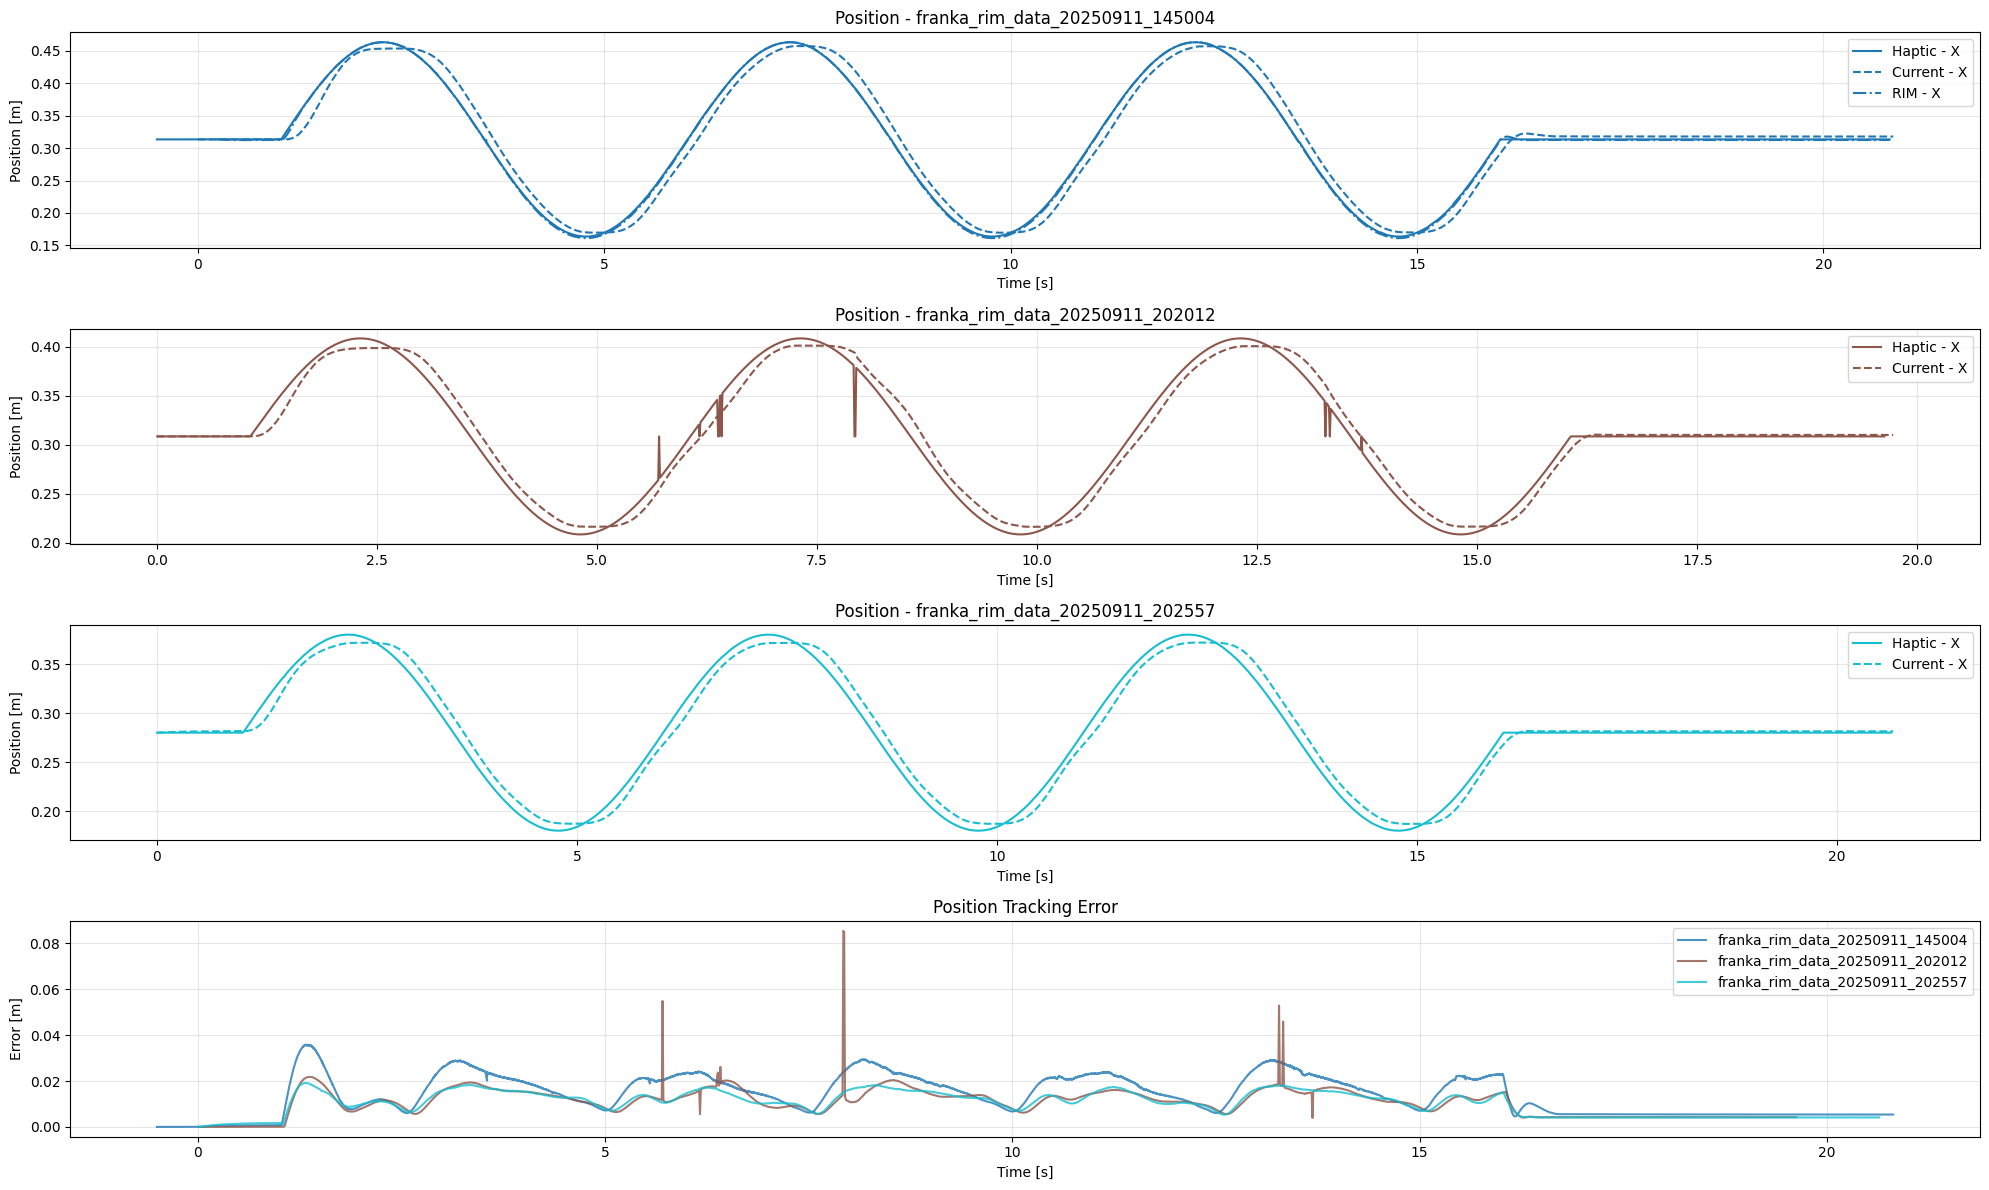

=== FORCE DATA COMPARISON ===


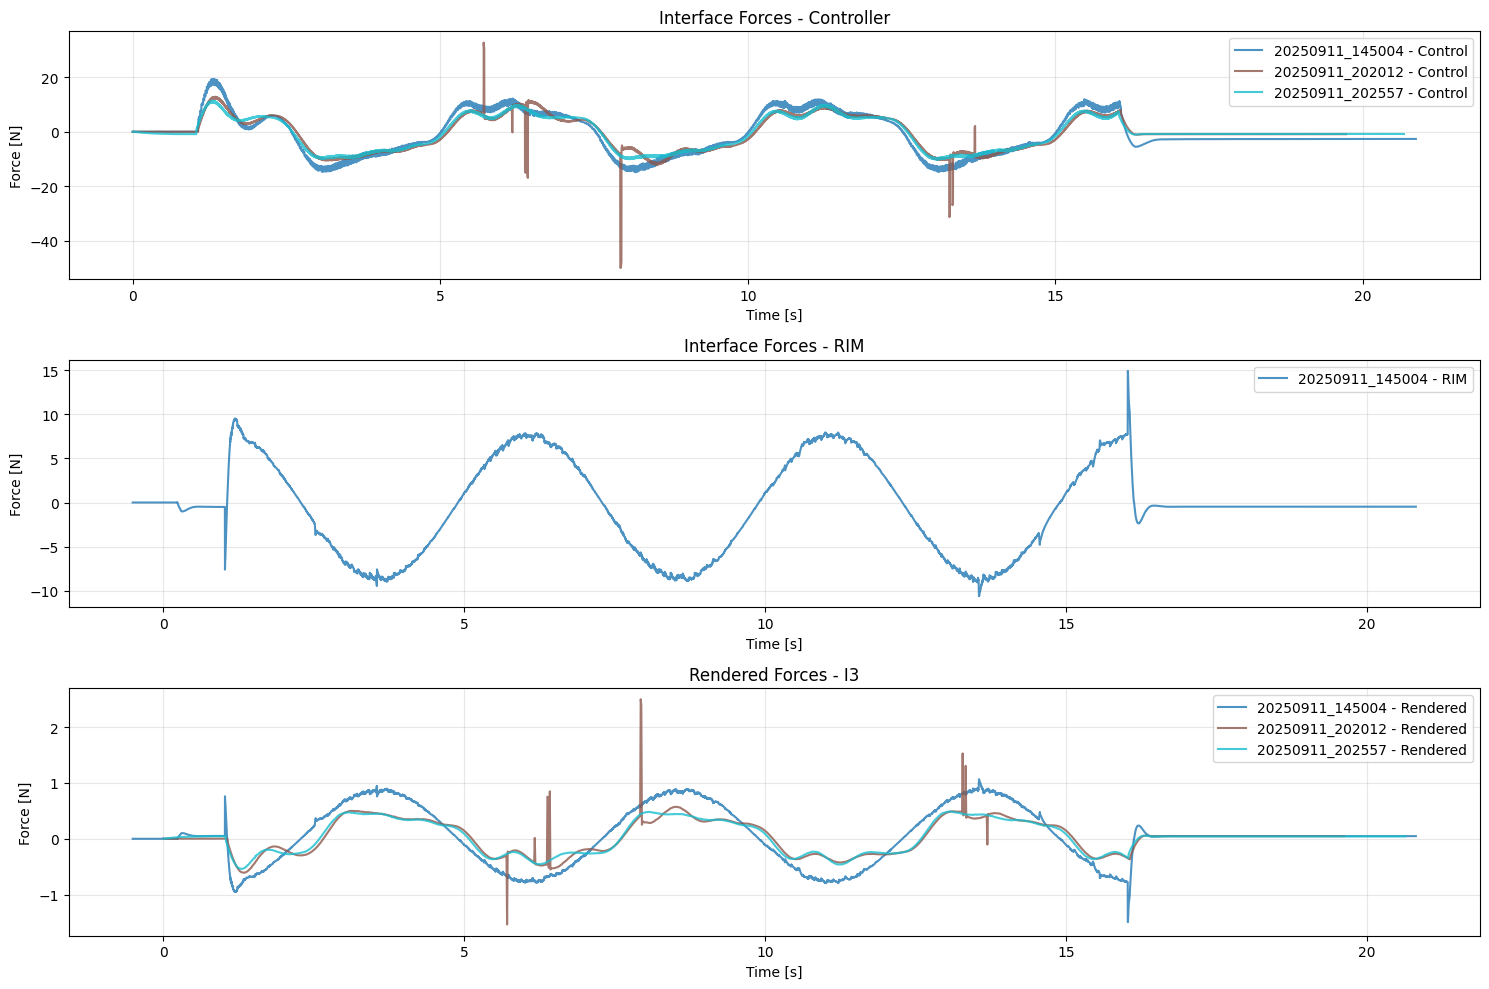


=== TRACKING PERFORMANCE ANALYSIS ===

franka_rim_data_20250911_145004 Tracking Performance:
  Mean Error: 0.0138 m
  RMS Error: 0.0161 m
  Max Error: 0.0359 m
  Std Error: 0.0083 m

franka_rim_data_20250911_202012 Tracking Performance:
  Mean Error: 0.0107 m
  RMS Error: 0.0123 m
  Max Error: 0.0855 m
  Std Error: 0.0060 m

franka_rim_data_20250911_202557 Tracking Performance:
  Mean Error: 0.0103 m
  RMS Error: 0.0115 m
  Max Error: 0.0192 m
  Std Error: 0.0050 m


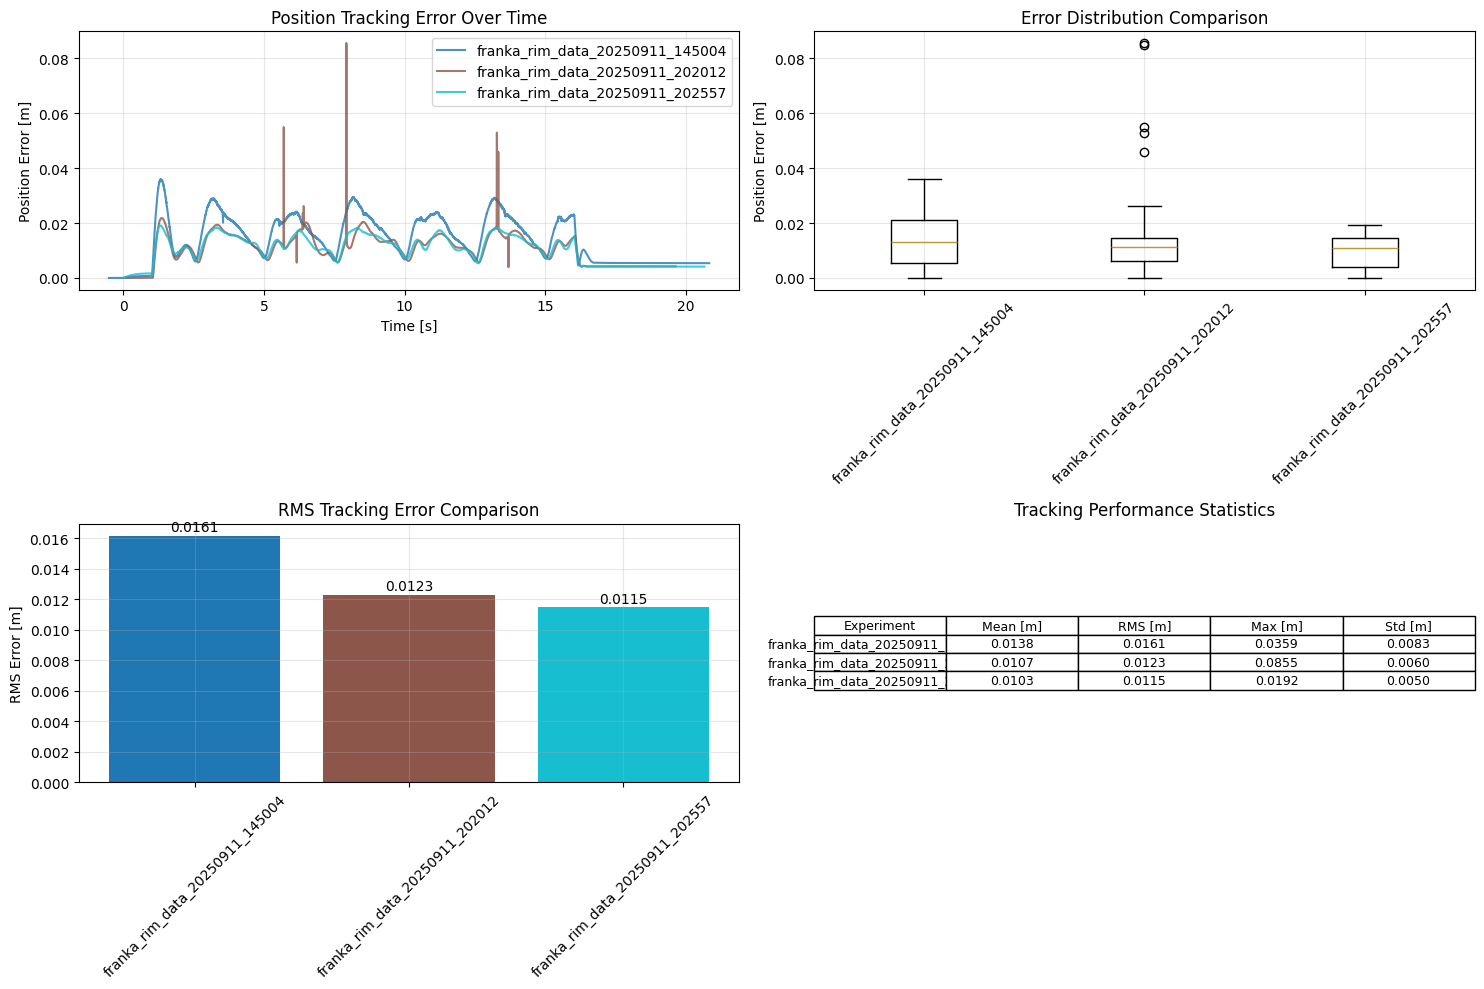


Tracking Statistics Summary:
                        experiment  mean_error  rms_error  max_error  \
0  franka_rim_data_20250911_145004    0.013828   0.016147   0.035854   
1  franka_rim_data_20250911_202012    0.010742   0.012306   0.085498   
2  franka_rim_data_20250911_202557    0.010328   0.011467   0.019156   

   std_error  median_error     min_error  
0   0.008338      0.012986  6.232368e-06  
1   0.006006      0.011127  4.530562e-07  
2   0.004985      0.010760  1.982933e-06  


In [52]:
# Import datetime for saving results
from datetime import datetime

# Analyze all experiments
if experiments_data:
    print("\n=== POSITION DATA COMPARISON ===")
    plot_position_comparison(experiments_data)

    print("=== FORCE DATA COMPARISON ===")
    plot_force_comparison(experiments_data)

    # print("\n=== DATA STRUCTURE DEBUG ===")
    # # Debug: check the structure of the dataframes
    # for exp_name, exp_data in experiments_data.items():
    #     print(f"\n{exp_name} DataFrame columns:")
    #     for df_name, df in exp_data["dataframes"].items():
    #         print(f"  {df_name}: {list(df.columns)}")

    print("\n=== TRACKING PERFORMANCE ANALYSIS ===")
    tracking_analysis = analyze_tracking_performance(experiments_data)

    if tracking_analysis:
        stats_df = plot_tracking_error_comparison(tracking_analysis)
        print("\nTracking Statistics Summary:")
        print(stats_df)

        # # Save results
        # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # results_file = DATA_DIR / f"tracking_analysis_{timestamp}.csv"
        # stats_df.to_csv(results_file, index=False)
        # print(f"\nResults saved to: {results_file}")

else:
    print("No experiment data found to analyze!")

## Save Results

Save analysis results and plots to files.

In [53]:
# Create output directory for analysis results
output_dir = DATA_DIR / "analysis_output"
output_dir.mkdir(exist_ok=True)

SAVE_RESULTS = False

if experiments_data and SAVE_RESULTS:
    # Generate timestamp for this analysis
    from datetime import datetime

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save plots
    print("Saving analysis plots...")
    plot_force_comparison(experiments_data, save_path=output_dir / f"force_comparison_{timestamp}.png")
    plot_position_comparison(experiments_data, save_path=output_dir / f"position_comparison_{timestamp}.png")

    if tracking_analysis:
        stats_df = plot_tracking_error_comparison(
            tracking_analysis, save_path=output_dir / f"tracking_analysis_{timestamp}.png"
        )

        # Save statistics as CSV
        stats_df.to_csv(output_dir / f"tracking_statistics_{timestamp}.csv")

        # Save detailed tracking data
        tracking_data_file = output_dir / f"tracking_data_{timestamp}.pkl"
        pd.to_pickle(tracking_analysis, tracking_data_file)

        print(f"Analysis results saved to: {output_dir}")
        print(f"Files created:")
        print(f"  - force_comparison_{timestamp}.png")
        print(f"  - position_comparison_{timestamp}.png")
        print(f"  - tracking_analysis_{timestamp}.png")
        print(f"  - tracking_statistics_{timestamp}.csv")
        print(f"  - tracking_data_{timestamp}.pkl")

    print("\nAnalysis complete!")